# Score Table

This notebook estimates the diffusion t-mean for synthetic data compared to the estimation using bridge sampling. Further time-complexity is estimated in this note book

In [10]:
from jaxgeometry.manifolds import *
from jaxgeometry.integration import dts
from jaxgeometry.autodiff import jacfwdx
from jaxgeometry.statistics import Frechet_mean
from jaxgeometry.statistics.score_matching import diffusion_mean
import jaxgeometry.statistics as jstat
import jaxgeometry.stochastics as jstoch
import jax.numpy as jnp
import haiku as hk
import jax
from jax import vmap

import pandas as pd

import os

import pickle

from tabulate import tabulate

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as tkr

from jaxgeometry.statistics.score_matching import model_loader
from models import models

In [11]:
plt.rcParams.update({'font.size': 20})
cbformat = tkr.ScalarFormatter()   # create the formatter
cbformat.set_powerlimits((-2,2)) 

# Load Estimation Error and Time

In [12]:
manifold = 'HypParaboloid'

In [13]:
path = f"../results/estimates/{manifold}.pkl"
figure_path = "../figures/timing/"
if not os.path.exists(figure_path):
    os.makedirs(figure_path)

In [14]:
with open(path, 'rb') as f:
    estimates = pickle.load(f)

## Score Table

### Plotting Estimates

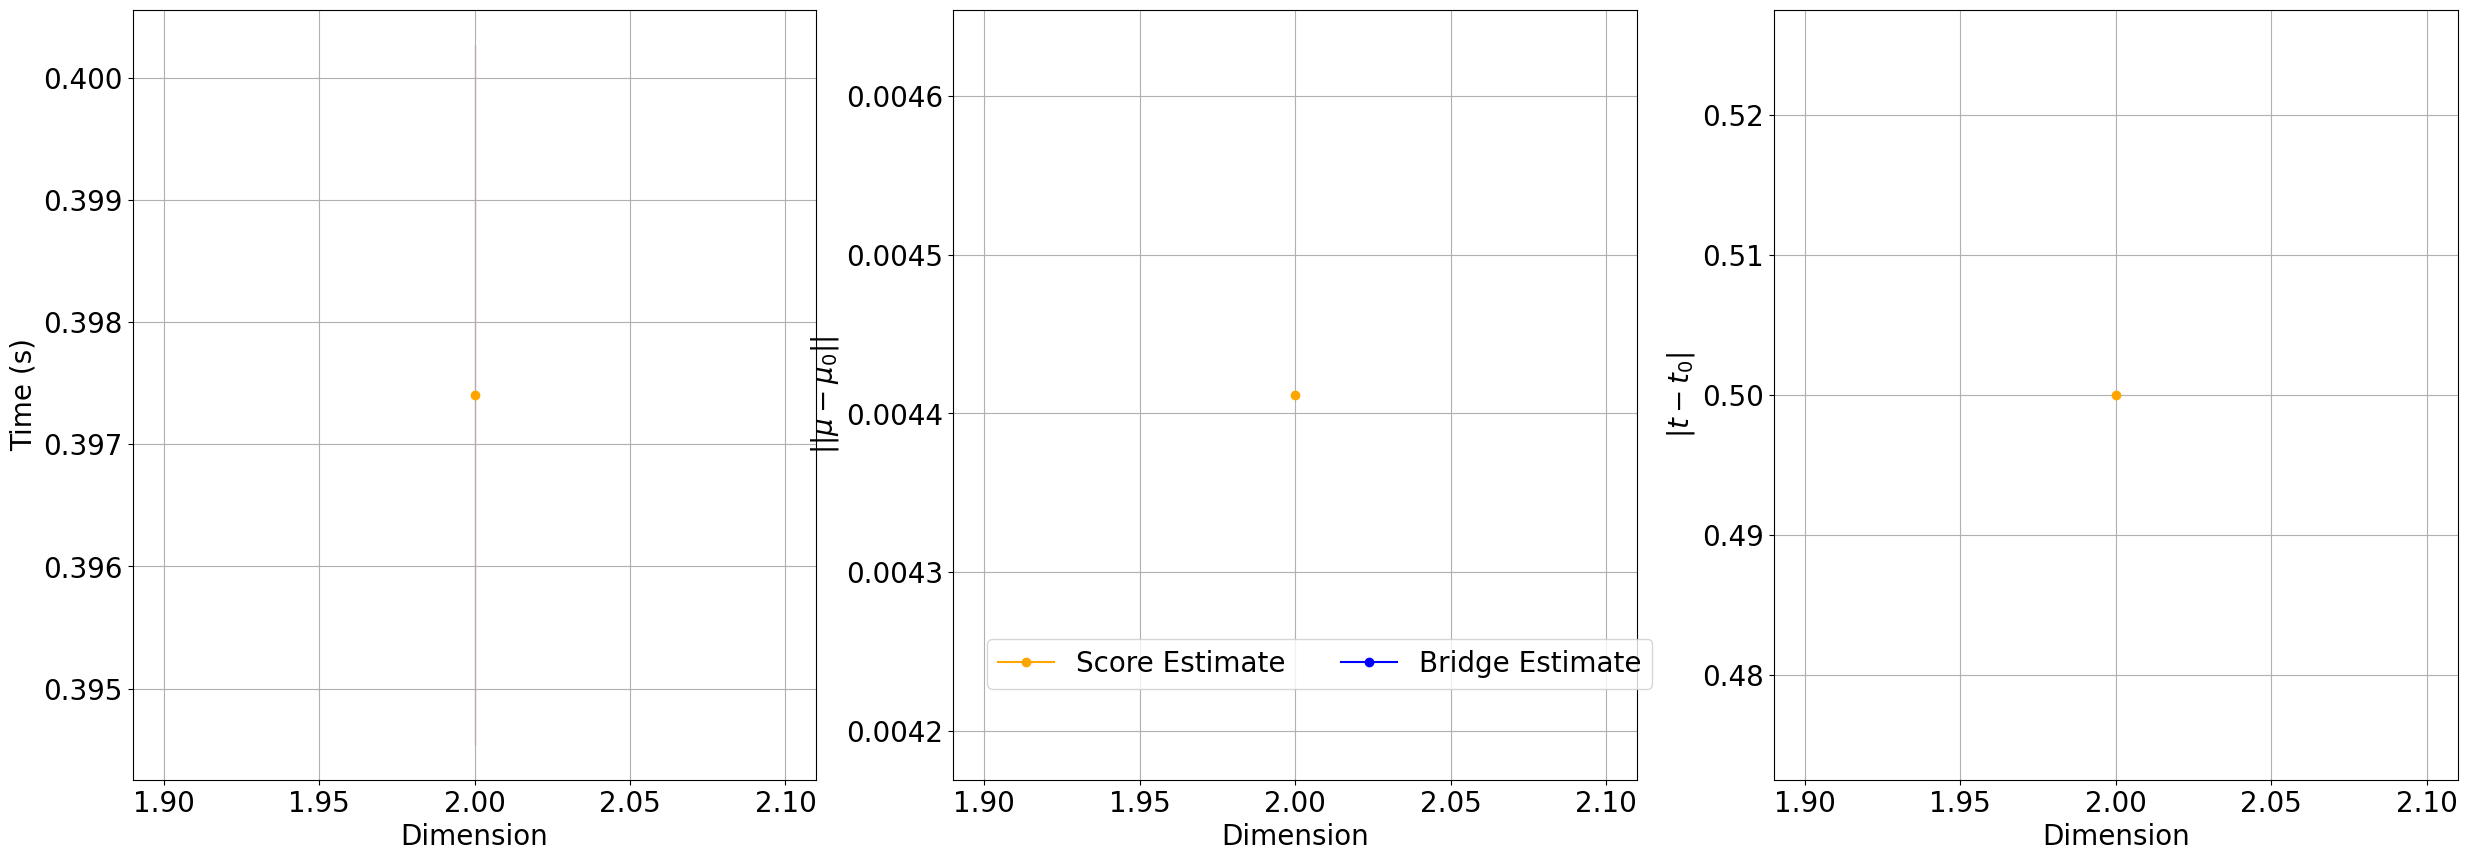

In [23]:
#Plotting time difference
fig = plt.figure(figsize=(30,10))
ax = fig.add_subplot(131)
ax.plot(estimates['dim'], 
        estimates['score_mu_time'], '-o',color='orange', label='Score Estimate')
ax.plot(estimates['dim'], 
        estimates['bridge_mu_time'], '-o',color='blue', label='Bridge Estimate')
ax.set_xlabel(f'Dimension')
ax.set_ylabel(f'Time (s)')
ax.fill_between(
    estimates['dim'],
    jnp.maximum(estimates['score_mu_time'] - 1.96 * estimates['score_std_time'], 
                jnp.zeros_like(estimates['score_mu_time'])),
    jnp.maximum(estimates['score_mu_time'] + 1.96 * estimates['score_std_time'], 
                jnp.zeros_like(estimates['score_mu_time'])),
    color="tab:red",
    alpha=0.5,
)
ax.fill_between(
    estimates['dim'],
    jnp.maximum(estimates['bridge_mu_time'] - 1.96 * estimates['bridge_std_time'], 
                jnp.zeros_like(estimates['bridge_mu_time'])),
    jnp.maximum(estimates['bridge_mu_time'] + 1.96 * estimates['bridge_std_time'], 
                jnp.zeros_like(estimates['bridge_mu_time'])),
    color="tab:pink",
    alpha=0.5,
)
ax.grid(True)

ax = fig.add_subplot(132)
ax.plot(estimates['dim'], 
        estimates['score_mu_error'], '-o',color='orange')
ax.plot(estimates['dim'], 
        estimates['bridge_mu_error'], '-o',color='blue')
ax.set_xlabel(f'Dimension')
ax.set_ylabel(r'$||\mu-\mu_{0}||$')
ax.grid(True)

ax = fig.add_subplot(133)
ax.plot(estimates['dim'], 
        estimates['score_t_error'], '-o',color='orange')
ax.plot(estimates['dim'], 
        estimates['bridge_t_error'], '-o',color='blue')
ax.set_xlabel(f'Dimension')
ax.set_ylabel(r'$|t-t_{0}|$')
ax.grid(True)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.40,0.2), ncol=5)

plt.show()

save_path = f'{figure_path}{manifold}.pdf'
fig.savefig(save_path, format='pdf', pad_inches=0.1, bbox_inches='tight')


### Table Estimates

In [24]:
names = [r"muscore", r"mubridge", 
        r"tscore", r"tbridge",
        r"dim", r"s1n", r"s2n", r'score_time', r'bridge_time']

table_dict = estimates.copy()
val = [f"{table_dict['score_mu_time'][i]:.4f} +/- {table_dict['score_std_time'][i]:.4f}" for i in range(len(table_dict['score_mu_time']))]
table_dict['score_time'] = val
val = [f"{table_dict['bridge_mu_time'][i]:.4f} +/- {table_dict['bridge_std_time'][i]:.4f}" for i in range(len(table_dict['score_mu_time']))]
table_dict['bridge_time'] = val
table_dict['s1_ntrain'] *= 10
table_dict['s2_ntrain'] *= 10
del table_dict['score_mu_time']
del table_dict['score_std_time']
del table_dict['bridge_mu_time']
del table_dict['bridge_std_time']

print(tabulate(table_dict, headers=names, floatfmt=".4f"))


  muscore    mubridge    tscore    tbridge    dim         s1n       s2n  score_time         bridge_time
---------  ----------  --------  ---------  -----  ----------  --------  -----------------  -------------
   0.0044         nan    0.5000        nan      2  50010.0000  950.0000  0.3974 +/- 0.0015  nan +/- nan


## Frechet Table

In [8]:
manifold = 'HypParaboloid'

In [9]:
path = f"../results/estimates/frechet_{manifold}.pkl"
figure_path = "../figures/timing/"
if not os.path.exists(figure_path):
    os.makedirs(figure_path)

In [10]:
with open(path, 'rb') as f:
    estimates = pickle.load(f)

### Plotting Estimates

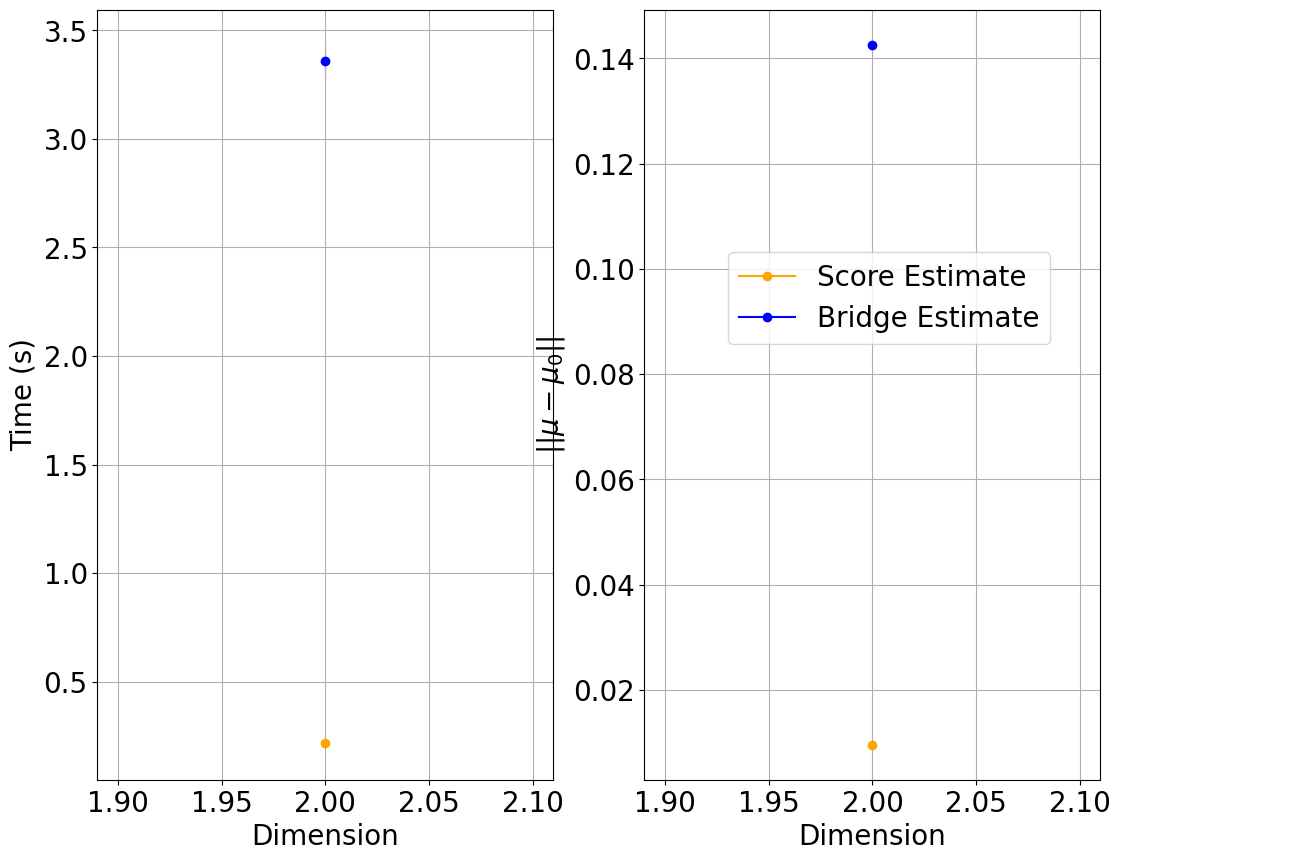

In [11]:
#Plotting time difference
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(131)
ax.plot(estimates['dim'], 
        estimates['score_mu_time'], '-o',color='orange', label='Score Estimate')
ax.plot(estimates['dim'], 
        estimates['frechet_mu_time'], '-o',color='blue', label='Bridge Estimate')
ax.set_xlabel(f'Dimension')
ax.set_ylabel(f'Time (s)')
ax.fill_between(
    estimates['dim'],
    jnp.maximum(estimates['score_mu_time'] - 1.96 * estimates['score_std_time'], 
                jnp.zeros_like(estimates['score_mu_time'])),
    jnp.maximum(estimates['score_mu_time'] + 1.96 * estimates['score_std_time'], 
                jnp.zeros_like(estimates['score_mu_time'])),
    color="tab:red",
    alpha=0.5,
)
ax.fill_between(
    estimates['dim'],
    jnp.maximum(estimates['frechet_mu_time'] - 1.96 * estimates['frechet_std_time'], 
                jnp.zeros_like(estimates['frechet_mu_time'])),
    jnp.maximum(estimates['frechet_mu_time'] + 1.96 * estimates['frechet_std_time'], 
                jnp.zeros_like(estimates['frechet_mu_time'])),
    color="tab:pink",
    alpha=0.5,
)
ax.grid(True)

ax = fig.add_subplot(132)
ax.plot(estimates['dim'], 
        estimates['score_mu_error'], '-o',color='orange')
ax.plot(estimates['dim'], 
        estimates['frechet_mu_error'], '-o',color='blue')
ax.set_xlabel(f'Dimension')
ax.set_ylabel(r'$||\mu-\mu_{0}||$')
ax.grid(True)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.56,0.6), ncol=1)

plt.show()

save_path = f'{figure_path}frechet_{manifold}.pdf'
fig.savefig(save_path, format='pdf', pad_inches=0.1, bbox_inches='tight')


### Table Estimates

In [12]:
names = [r"muscore", r"mufrechet", 
        r"dim", r"s1n", r"s2n", r'score_time', r'frechet_time']

table_dict = estimates.copy()
val = [f"{table_dict['score_mu_time'][i]:.4f} +/- {table_dict['score_std_time'][i]:.4f}" for i in range(len(table_dict['score_mu_time']))]
table_dict['score_time'] = val
val = [f"{table_dict['frechet_mu_time'][i]:.4f} +/- {table_dict['frechet_mu_time'][i]:.4f}" for i in range(len(table_dict['frechet_mu_time']))]
table_dict['frechet_time'] = val
table_dict['s1_ntrain'] *= 10
table_dict['s2_ntrain'] *= 10
del table_dict['score_mu_time']
del table_dict['score_std_time']
del table_dict['frechet_mu_time']
del table_dict['frechet_std_time']

print(tabulate(table_dict, headers=names, floatfmt=".4f"))

  muscore    mufrechet    dim         s1n    s2n  score_time         frechet_time
---------  -----------  -----  ----------  -----  -----------------  -----------------
   0.0096       0.1426      2  50010.0000    nan  0.2173 +/- 0.0037  3.3592 +/- 3.3592


### Testing

In [262]:
loss_type = 'dsmdiagvr'
data_path = '../data/'
s2_type = "s2"
generator_dim = 2
if loss_type == "dsmdiagvr":
    s1_path = f"scores/{manifold}2/s1_dsmvr/"
elif loss_type == "dsmdiag":
    s1_path = f"scores/{manifold}2/s1_dsm/"
else:
    s1_path = f"scores/{manifold}2/s1_{loss_type}/"
s2_path = f"scores/{manifold}2/{s2_type}_{loss_type}/"
data_path = f"{data_path}{manifold}2/"
from jaxgeometry.statistics.score_matching.model_loader import load_model

if 2<10:
    layers = [50,100,100,50]
elif 2<50:
    layers = [50,100,200,200,100,50]
else:
    layers = [50,100,200,400,400,200,100,50]

s1_ntrain = []
s2_ntrain = []
s1_state = load_model(s1_path)
#s1_ntrain.append(len(jnp.load(''.join((s1_path, 'loss_arrays.npy')))))
if 1:
    s2_state = load_model(s2_path)
    #s2_ntrain.append(len(jnp.load(''.join((s2_path, 'loss_arrays.npy')))))
else:
    s2_state = None
    s2_ntrain.append(jnp.nan)

s1_model = hk.transform(lambda x: models.MLP_s1(dim=generator_dim, layers=layers)(x))

if s2_type == "s2":
    s2_model = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                    dim=generator_dim, r = max(generator_dim//2,1))(x))
elif s2_type == "s1s2":
    @hk.transform
    def s2_model(x):

        s1s2 =  models.MLP_s1s2(
            models.MLP_s1(dim=generator_dim, layers=layers), 
            models.MLP_s2(layers_alpha=layers, 
                          layers_beta=layers,
                          dim=generator_dim,
                          r = max(generator_dim//2,1))
            )

        return s1s2(x)[1]

In [263]:
from jaxgeometry.statistics.score_matching import ScoreEvaluation
M = HypParaboloid()
method = 'Local'
x0 = M.coords([0.]*2)
ScoreEval = ScoreEvaluation(M, 
                                    s1_model=s1_model, 
                                    s1_state=s1_state, 
                                    s2_model=s2_model, 
                                    s2_state=s2_state,
                                    s2_approx=1, 
                                    method=method, 
                                    seed=2712)
        
xs = pd.read_csv(''.join((data_path, 'xs.csv')), header=None)
charts = pd.read_csv(''.join((data_path, 'chart.csv')), header=None)
X_obs = (jnp.array(xs.values), jnp.array(charts.values))

using M.Exp for Logarithm


In [264]:
t_grid = jnp.linspace(0.1,1,100)
x02 = (jnp.array([-0.00659089,  0.0058661 ]), jnp.zeros(1))
val = vmap(lambda t: jnp.mean(vmap(lambda x,c: ScoreEval.gradt_log(x0, (x,c), t))(X_obs[0],X_obs[1])))(t_grid)

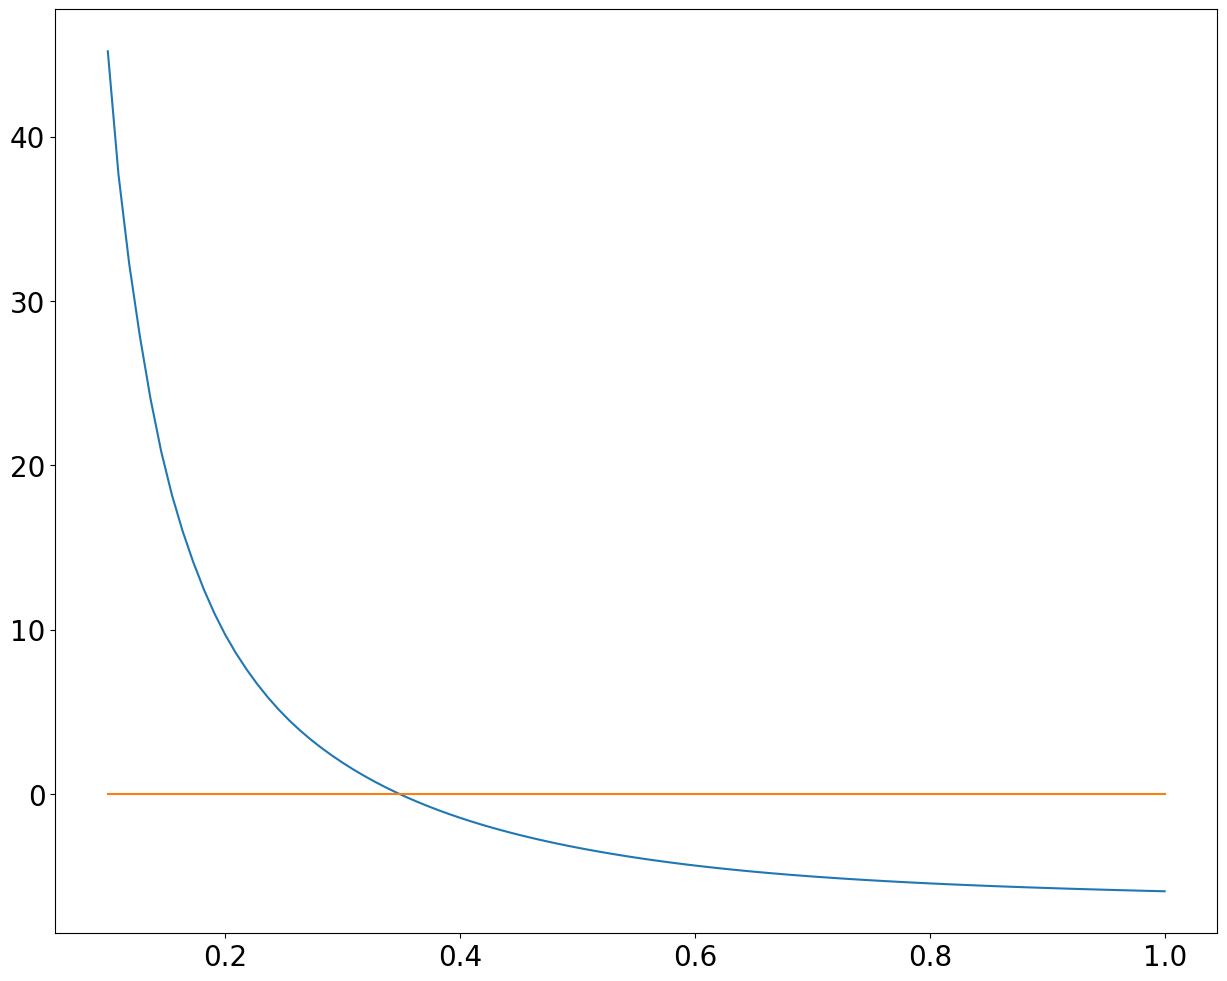

In [265]:
plt.plot(t_grid, val)
plt.plot(t_grid, 0*val)

In [56]:
M.Gamma_g(x0)

Array([[[0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.]]], dtype=float32)

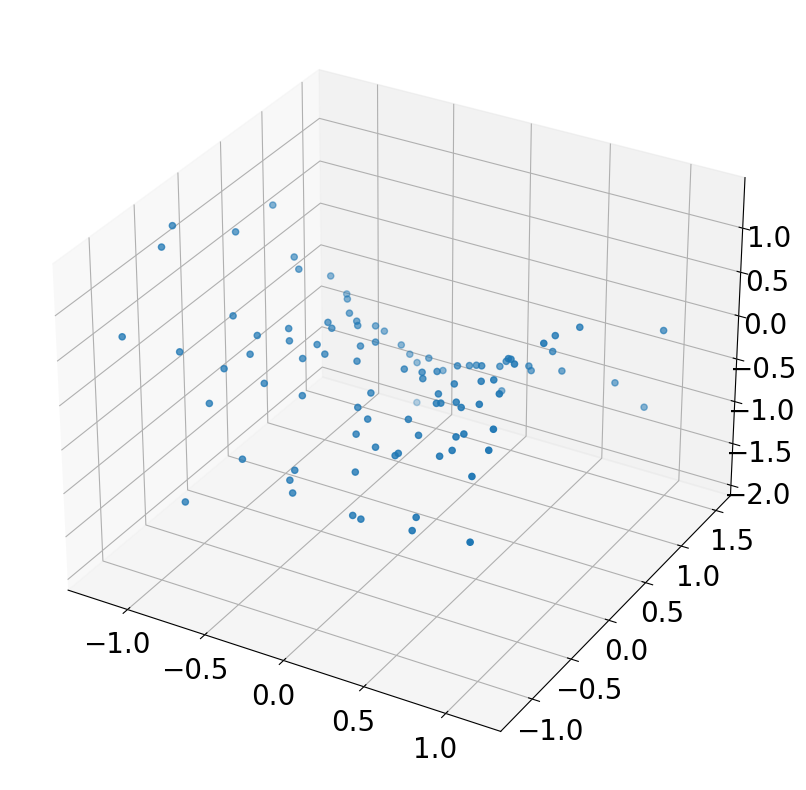

In [57]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(X_obs[0][:,0], X_obs[0][:,1], X_obs[0][:,0]**2-X_obs[0][:,1]**2)

In [109]:
X_obs[1][:,0]

Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

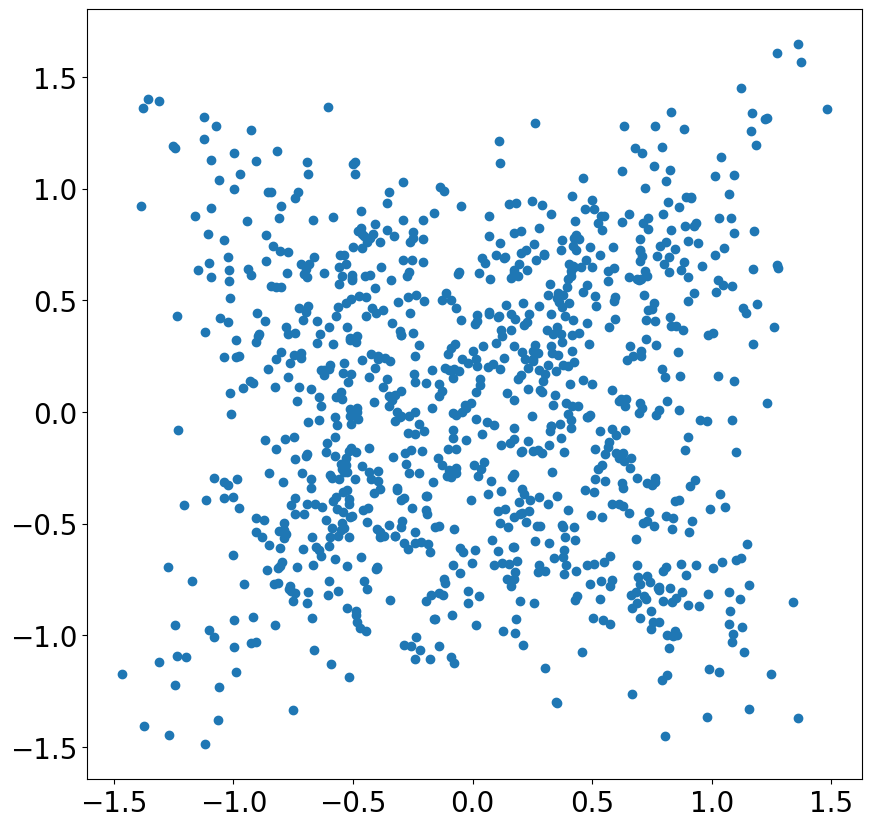

In [111]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.scatter(X_obs[0][:,0], X_obs[0][:,1])